In [4]:
import numpy as np
import pandas as pd
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from tqdm.auto import tqdm
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from aging.plotting import (
    figure,
    format_plots,
    add_identity,
    legend,
    PlotConfig,
    save_factory,
)
from copy import deepcopy
from operator import or_
from toolz import reduce, valmap, keyfilter, pluck, dissoc
from aging.behavior.bio_age_model import fit_model, masked_xval, model_fun_v5, get_biological_age, compute_concentrations, concentration_interpolation, create_masks, expected_counts, compute_heldout_r2, model_setup, model_fun_v2
from scipy.spatial.distance import pdist, squareform

## Re-sorted behavioral distance matrices

In [1]:
from scipy.spatial.distance import pdist, squareform

In [6]:
def zscore(ser: pd.Series):
    return (ser - ser.mean()) / ser.std()


def demean(ser: pd.Series):
    return ser - ser.mean()


def quantile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'q_{:0.02f}'.format(n)
    return percentile_


In [8]:
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_counts_matrix_v00.parquet"
)
df = df[keep_syllables]
mask = df.index.get_level_values("age") < 100
df = df[mask].copy()

size_df = pd.read_parquet(
    '/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_mouse_area_df_v00.parquet'
)
mask = size_df.index.get_level_values("age") < 100
size_df = size_df[mask].copy()
age_cut = pd.cut(size_df.index.get_level_values('age'), 19)

size_df.loc[size_df['quant_0.5'] == 0, 'quant_0.5'] = np.nan
sizes_col = size_df['quant_0.5']
sizes_col = sizes_col.groupby('mouse').apply(lambda df: df.sort_index(level='age').interpolate()).droplevel(0)

sizes_col = zscore(sizes_col.groupby(age_cut, observed=True).transform(demean))
sizes_col = sizes_col.fillna(0)
sizes_col = sizes_col.loc[df.index]

# make sure df matches sizes
df = df.loc[sizes_col.index]

age = jnp.array(df.index.get_level_values("age"))
syllable_counts_jax = jnp.array(df.astype(float))

In [10]:
features = {
    "ages": age,  # models >= 1
    "counts": syllable_counts_jax + 1,  # models >= 1
    "sizes": sizes_col.to_numpy(),  # models > 1
    # "mice": mouse_ids,  # models > 2
}

hypparams = {
    "min_age": 1,
    "max_age": age.max() + 5,
    "age_sd": 9,  # weeks
    "n_age_samples": 504,
    "n_splines": 4,
    "n_syllables": syllable_counts_jax.shape[1],
    "n_development_splines": 4,
    "scale": 150,
    "normalize_by_softmax": True,
    "n_keep_sylls": 25,
    "n_sessions": len(syllable_counts_jax),
    # "n_animals": len(mouse_ids),
    "lr": 0.2,
    "n_opt_iter": 350,
}

In [12]:
mdl = fit_model(features, hypparams, 2)

In [14]:
df_copy = df.copy()
df_copy['beh_age'] = mdl['bio_ages']
df_copy = df_copy.set_index('beh_age', append=True)

Text(0, 0.5, 'Session (sorted by chron. age)')

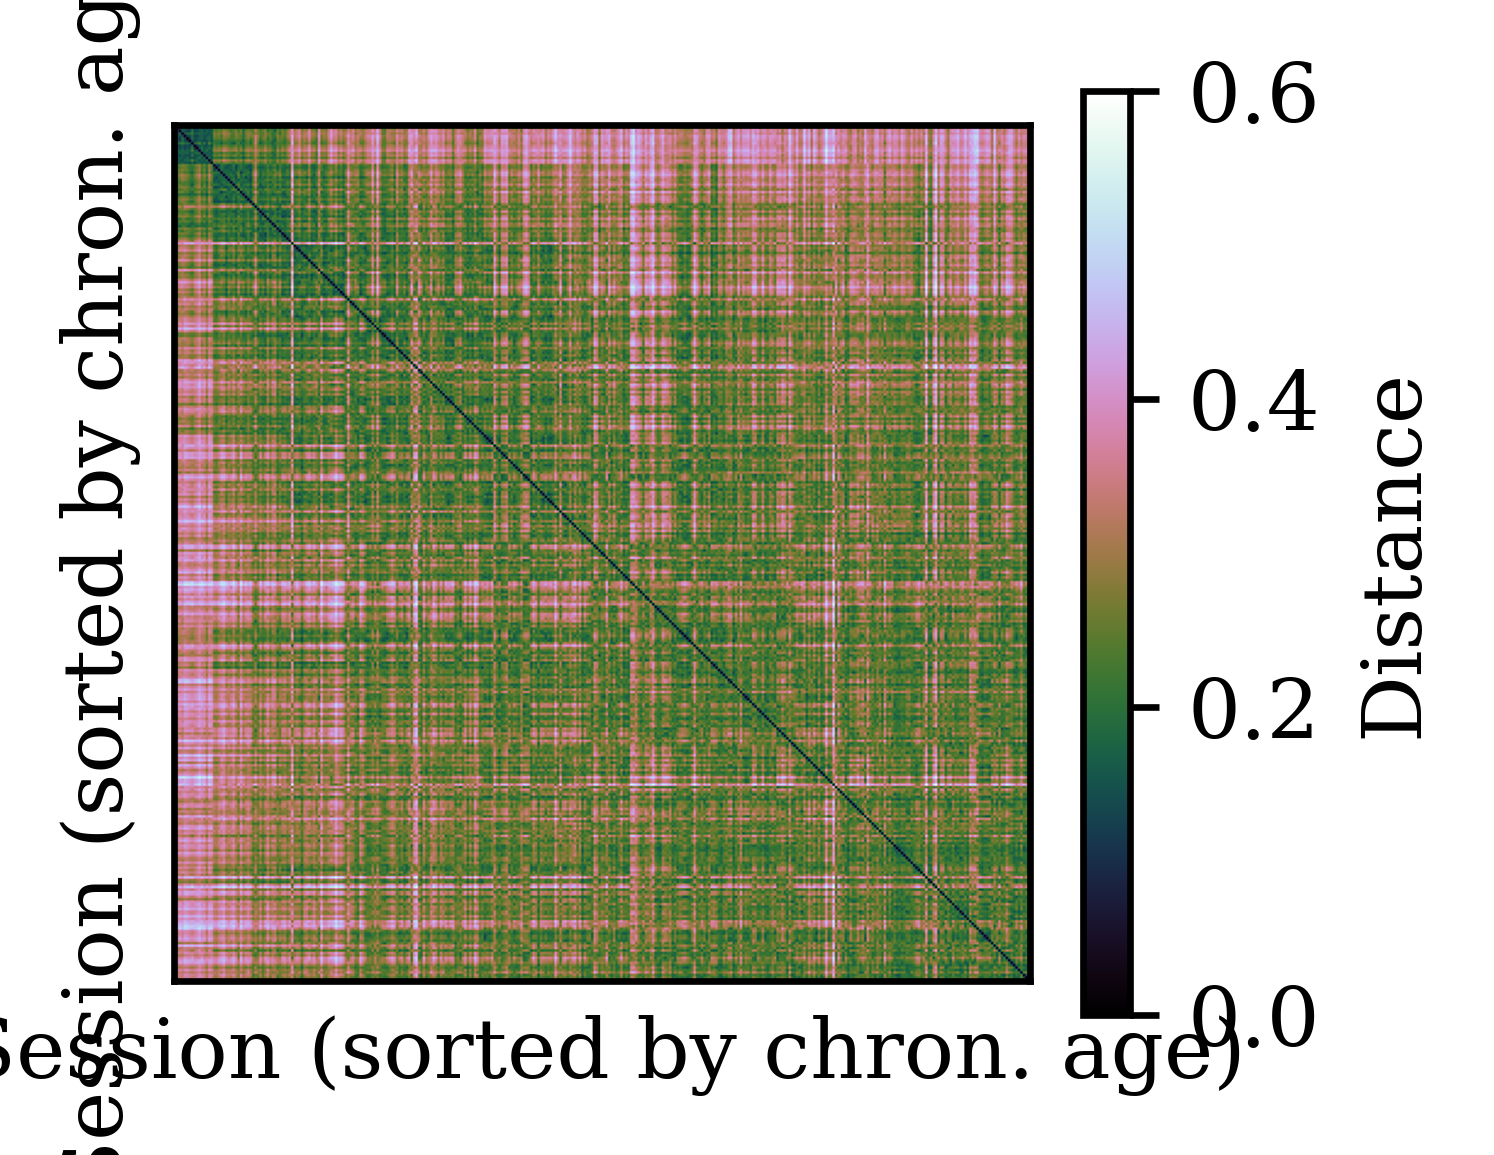

In [15]:
fig = figure(2.3, 2)
d = pdist(df.sort_index(level='age'), metric='jensenshannon')
d = squareform(d)
plt.imshow(d, cmap='cubehelix', vmax=0.6)
plt.colorbar(label="Distance")
plt.xticks([])
plt.yticks([])
plt.xlabel('Session (sorted by chron. age)')
plt.ylabel('Session (sorted by chron. age)')
# saver(fig, 'longtogeny-chron-age-distance-matrix');

Text(0, 0.5, 'Session (sorted by beh. age)')

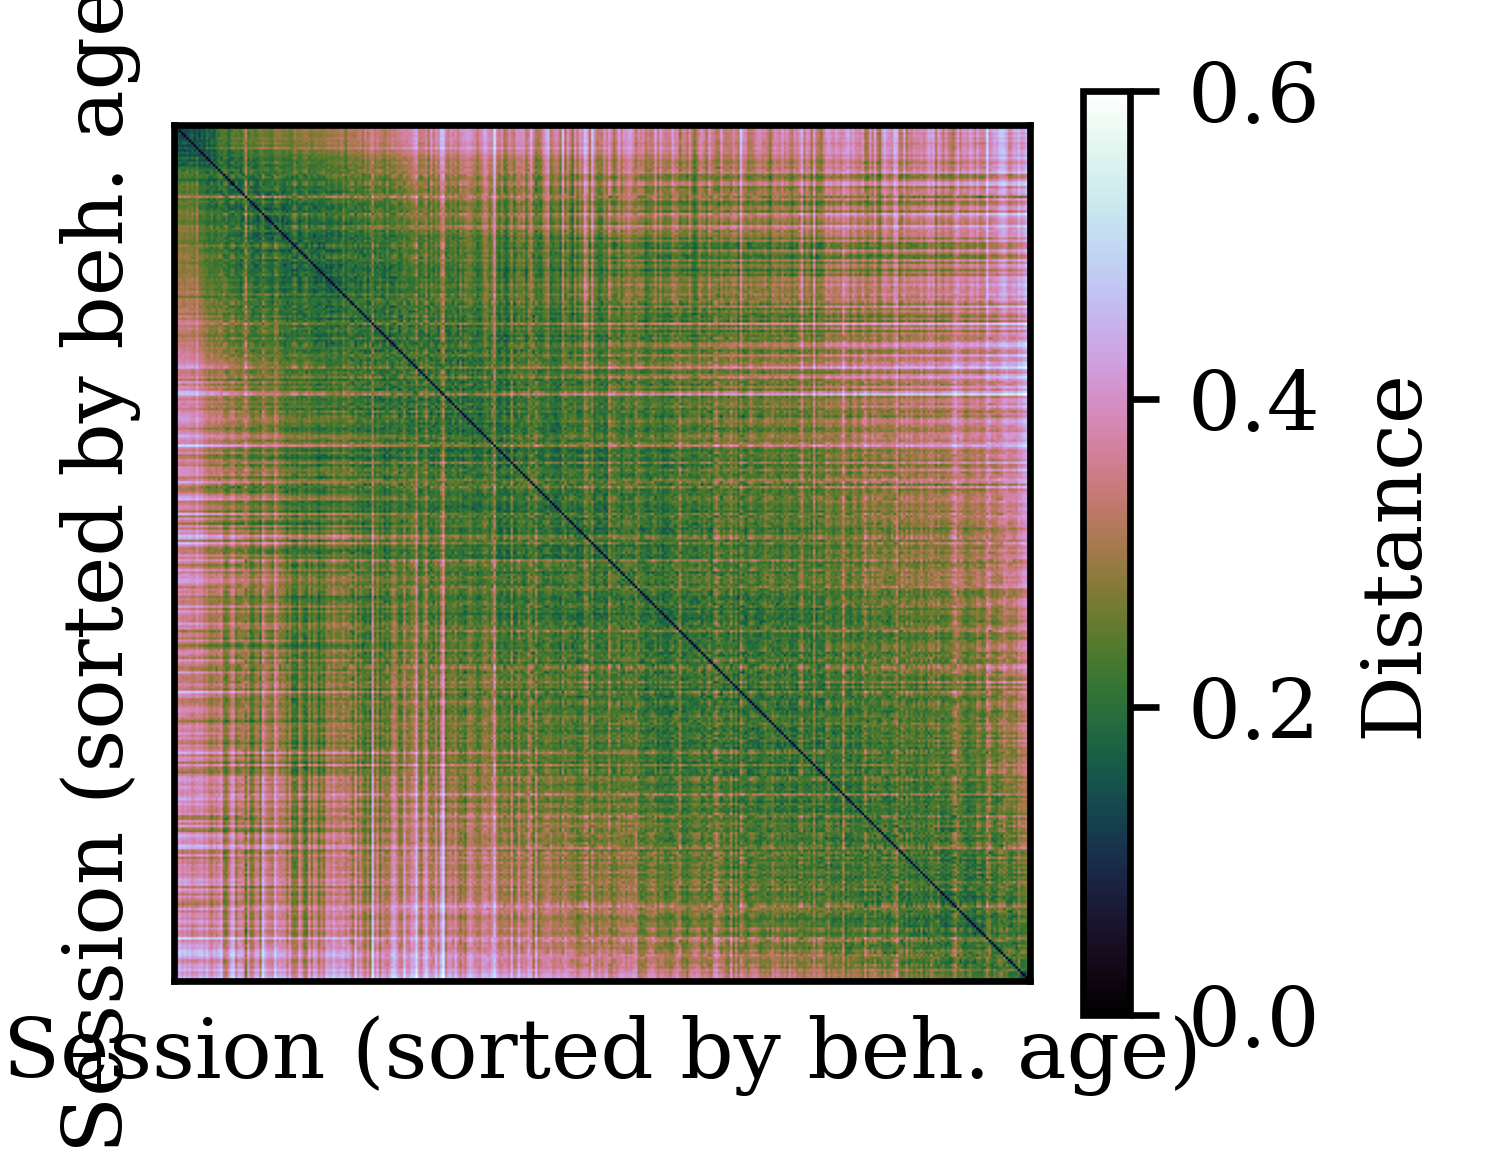

In [16]:
fig = figure(2.3, 2)
d = pdist(df_copy.sort_index(level='beh_age'), metric='jensenshannon')
d = squareform(d)
plt.imshow(d, cmap='cubehelix', vmax=0.6)
plt.colorbar(label="Distance")
plt.xticks([])
plt.yticks([])
plt.xlabel('Session (sorted by beh. age)')
plt.ylabel('Session (sorted by beh. age)')
# saver(fig, 'longtogeny-beh-age-distance-matrix');